<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/geometrie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch


def extractCropOld(ABCD, img, s=256, inner=2048):
    EPS, img = 0.1, img
    _, H, W = img.shape
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    tmp = (torch.arange(inner).float() + 0.5) / inner
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    mask = (u + v <= 1.001).float()
    maskbis = (u + v <= 1.001).float()

    rP = (rB - rA) * u + (rD - rA) * v + rA
    rPc = torch.clamp(rP, EPS, H - EPS)
    cP = (cB - cA) * u + (cD - cA) * v + cA
    cPc = torch.clamp(cP, EPS, W - EPS)
    rP, cP = rPc.long().flatten(), cPc.long().flatten()
    out1 = img[:, rP, cP].view(3, inner, inner) * mask.view(1, inner, inner)

    rP = (rD - rC) * u + (rB - rC) * v + rC
    rPc = torch.clamp(rP, EPS, H - EPS)
    cP = (cD - cC) * u + (cB - cC) * v + cC
    cPc = torch.clamp(cP, EPS, W - EPS)
    rP, cP = rPc.long().flatten(), cPc.long().flatten()
    out2 = img[:, rP, cP].view(3, inner, inner) * mask.view(1, inner, inner)
    out2 = torch.flip(out2, dims=[1, 2])
    maskbis = torch.flip(maskbis, dims=[0, 1])

    mask = (mask + maskbis + EPS).view(1, 1, inner, inner)
    out = (out1 + out2).view(1, 3, inner, inner) / mask
    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

def extractCrop(ABCD, img, s=256, inner=2048):
    # find M such that
    # M(0 0 1) = A
    # M(inner 0 1) = B
    # M(inner inner 1) = C
    # M(0 inner 1) = D
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    P = torch.ones(3,4)
    P[0,0],P[1,0]=0,0
    P[0,1],P[1,1]=inner,0
    P[0,2],P[1,2]=inner,inner
    P[0,3],P[1,3]=0,inner

    Q = torch.ones(3,4)
    Q[0,0],Q[1,0]=rA,cA
    Q[0,1],Q[1,1]=rB,cB
    Q[0,2],Q[1,2]=rC,cC
    Q[0,3],Q[1,3]=rD,cD

    #XP=Q -> X = QP^{-1} pseudo inverse
    M = torch.matmul(Q,torch.linalg.pinv(P))

    tmp = torch.arange(inner).float()
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    uv = torch.stack([u,v,torch.ones(inner,inner)],dim=0)

    uv = torch.matmul(M,uv.flatten(1)).long()
    out = img[:, uv[0], uv[1]].view(1,3,inner,inner)

    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

In [38]:
def baddrawsegment(img,AB, inner = 2048):
    rA, cA, rB, cB = AB
    for i in range(2048):
        r = rA*(1.-i/2048)+i/2048*rB
        c = cA*(1.-i/2048)+i/2048*cB
        img[:,int(r),int(c)]=0

def baddrawrect(img,ABCD):
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD
    baddrawsegment(img,(rA, cA, rB, cB))
    baddrawsegment(img,(rC, cC, rD, cD))
    baddrawsegment(img,(rA, cA, rD, cD))
    baddrawsegment(img,(rB, cB, rC, cC))

In [39]:
import torchvision
import os

if not os.path.exists("build/5495485981_3293917c4c_z.jpg"):
    os.system("wget http://farm6.staticflickr.com/5300/5495485981_3293917c4c_z.jpg")
img = torchvision.io.read_image("5495485981_3293917c4c_z.jpg") / 255.0

_, H, W = img.shape
ABCD = [30.0, 30.0, H - 70.0, 30.0, H - 180.0, W * 2 // 3+50, 140.0, W * 2 // 3+50]
crop = extractCrop(ABCD,img)
oldcrop = extractCropOld(ABCD,img)
baddrawrect(img,ABCD)
cropbis = extractCrop(ABCD,img)
oldcropbis = extractCropOld(ABCD,img)

In [40]:
import matplotlib.pyplot as plt
def visuimage(img):
    visu = torch.stack([img[0],img[1],img[2]],dim=-1)
    plt.imshow(visu)
    plt.axis('off')
    plt.show()

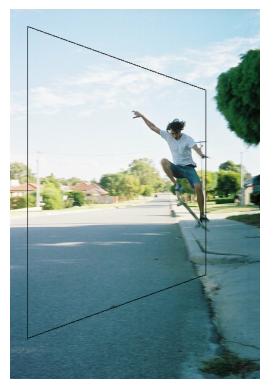

In [41]:
visuimage(img)


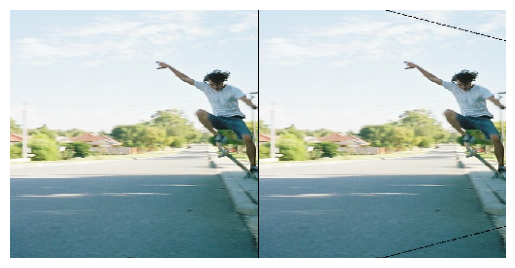

In [42]:
visuimage(torch.cat([crop,cropbis],dim=-1))

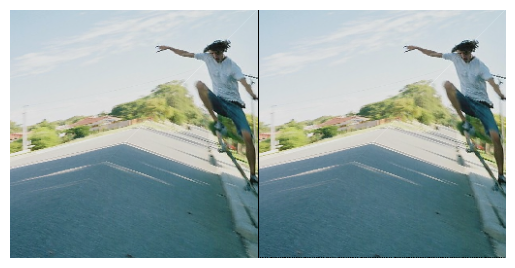

In [43]:
visuimage(torch.cat([oldcrop,oldcropbis],dim=-1))

In [44]:
def estimation(P,Q):
    mask = torch.ones(3,3)
    mask[2,:]=0
    bias = torch.zeros(3,3)
    bias[2,2]=1
    M = torch.nn.Parameter(torch.matmul(Q,torch.linalg.pinv(P)))
    optimizer = torch.optim.SGD([M],lr = 0.001)

    for i in range(1000):
        tmp = torch.matmul(M,P)-Q
        loss = (tmp*tmp).sum()

        optimizer.zero_grad()
        loss.backward()

        with torch.no_grad():
            M.grad = M.grad.sign()*0.01 + torch.clamp(M.grad,-1.,1.)

        optimizer.step()

        if i%100==99:
            print(float(loss))

    return M

In [45]:
def extractCropNew(ABCD, img, s=256, inner=2048):
    # find M such that
    # M(0 0 1) = A
    # M(inner 0 1) = B
    # M(inner inner 1) = C
    # M(0 inner 1) = D
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    P = torch.ones(3,4)
    P[0,0],P[1,0]=0,0
    P[0,1],P[1,1]=inner,0
    P[0,2],P[1,2]=inner,inner
    P[0,3],P[1,3]=0,inner

    Q = torch.ones(3,4)
    Q[0,0],Q[1,0]=rA,cA
    Q[0,1],Q[1,1]=rB,cB
    Q[0,2],Q[1,2]=rC,cC
    Q[0,3],Q[1,3]=rD,cD

    #XP=Q -> X = QP^{-1} pseudo inverse
    M = estimation(P,Q)

    tmp = torch.arange(inner).float()
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    uv = torch.stack([u,v,torch.ones(inner,inner)],dim=0)

    uv = torch.matmul(M,uv.flatten(1)).long()
    out = img[:, uv[0], uv[1]].view(1,3,inner,inner)

    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

12101.0078125
12101.0341796875
12101.0517578125
12101.0654296875
12101.07421875
12101.07421875
12101.0849609375
12101.0947265625
12101.0888671875
12101.0908203125


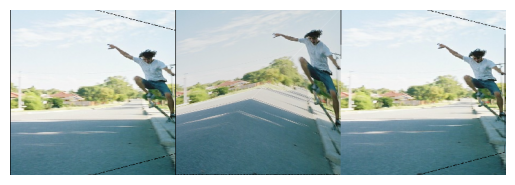

In [46]:
img = torchvision.io.read_image("5495485981_3293917c4c_z.jpg") / 255.0
baddrawrect(img,ABCD)
crop = extractCrop(ABCD,img)
oldcrop = extractCropOld(ABCD,img)
newcrop = extractCropNew(ABCD,img)
visuimage(torch.cat([crop,oldcrop,newcrop],dim=-1))

30157.08984375
30157.09765625
30157.103515625
30157.1171875
30157.123046875
30157.126953125
30157.12890625
30157.1328125
30157.1328125
30157.134765625


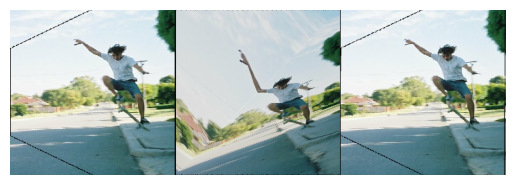

In [47]:
img = torchvision.io.read_image("5495485981_3293917c4c_z.jpg") / 255.0
ABCD = [H*0.3, 100, H*0.6,100, H - 70.0, W*0.9, 30.0, W*0.9]
baddrawrect(img,ABCD)
crop = extractCrop(ABCD,img)
oldcrop = extractCropOld(ABCD,img)
newcrop = extractCropNew(ABCD,img)
visuimage(torch.cat([crop,oldcrop,newcrop],dim=-1))

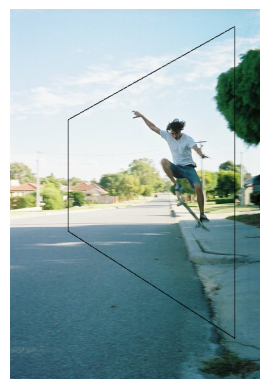

In [48]:
visuimage(img)

mais pourquoi l'erreur est pas à 0 ?????????

In [61]:
def normalize_points(points):
    """
    Normalize a set of 2D homogeneous points.

    Parameters:
        points (numpy array): 3xN matrix of homogeneous coordinates.

    Returns:
        points_norm (numpy array): Normalized 3xN matrix of homogeneous coordinates.
        T (numpy array): 3x3 transformation matrix used for normalization.
    """
    # Convert to inhomogeneous coordinates (remove the homogeneous component)
    points_inhomo = points[:2, :] / points[2, :]

    # Compute centroid
    centroid = torch.mean(points_inhomo, axis=1)

    # Compute scaling factor
    dists = torch.linalg.norm(points_inhomo - centroid.reshape(2, 1), axis=0)
    scale = 1.4 / torch.mean(dists)

    # Construct the normalization matrix T
    T = torch.Tensor([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])

    # Apply normalization
    points_norm = T @ points

    return points_norm, T

def estimation(U, V):
    """
    Compute the homography matrix M such that M * U = V.

    Parameters:
        U (numpy array): 3xN matrix of homogeneous coordinates of points in ABCD.
        V (numpy array): 3xN matrix of homogeneous coordinates of points in PQRS.

    Returns:
        M (numpy array): 3x3 homography matrix.
    """
    # Normalize the points
    U_norm, T_U = normalize_points(U)
    V_norm, T_V = normalize_points(V)

    N = U.shape[1]  # Number of points

    # Construct the matrix A for the linear system A * h = 0
    A = []
    for i in range(N):
        x, y, _ = U_norm[:, i]
        u, v, _ = V_norm[:, i]
        A.append([x, y, 1, 0, 0, 0, -u * x, -u * y, -u])
        A.append([0, 0, 0, x, y, 1, -v * x, -v * y, -v])
    A = torch.Tensor(A)

    # Solve for h using SVD (singular value decomposition)
    _, _, Vt = torch.linalg.svd(A)
    h = Vt[-1, :]  # The last row of Vt is the solution

    # Reshape h into the 3x3 homography matrix M_norm
    M_norm = h.reshape(3, 3)

    # Denormalize the homography matrix
    M = torch.linalg.inv(T_V) @ M_norm @ T_U

    # Normalize M so that M[2, 2] = 1
    M = M / M[2, 2]

    return M

In [53]:
def extractCropNew(ABCD, img, s=256, inner=2048):
    # find M such that
    # M(0 0 1) = A
    # M(inner 0 1) = B
    # M(inner inner 1) = C
    # M(0 inner 1) = D
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    P = torch.ones(3,4)
    P[0,0],P[1,0]=0,0
    P[0,1],P[1,1]=inner,0
    P[0,2],P[1,2]=inner,inner
    P[0,3],P[1,3]=0,inner

    Q = torch.ones(3,4)
    Q[0,0],Q[1,0]=rA,cA
    Q[0,1],Q[1,1]=rB,cB
    Q[0,2],Q[1,2]=rC,cC
    Q[0,3],Q[1,3]=rD,cD

    #XP=Q -> X = QP^{-1} pseudo inverse
    M = estimation(P,Q)

    tmp = torch.arange(inner).float()
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    uv = torch.stack([u,v,torch.ones(inner,inner)],dim=0)

    uv = torch.matmul(M,uv.flatten(1)).long()
    out = img[:, uv[0], uv[1]].view(1,3,inner,inner)

    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

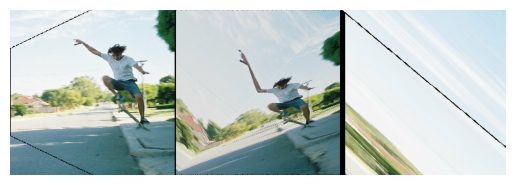

In [62]:
crop = extractCrop(ABCD,img)
oldcrop = extractCropOld(ABCD,img)
newcrop = extractCropNew(ABCD,img)
visuimage(torch.cat([crop,oldcrop,newcrop],dim=-1))

deepseek pas encore prêt XD